In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns
import glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2020-10-27 20:47.


In [2]:
def adata_louvain_name_convert(inputAdata, orderDf, louvainNewOrdered, louvainOldOrdered):
    inputAdata.obs["louvain_celltype"] = ["%s_%s"%(x,y) for index, (x,y) in enumerate(zip(inputAdata.obs['louvain'], inputAdata.obs['cell_type']))]
    inputAdata.obs["celltype_general"] = [x[0] for x in inputAdata.obs['cell_type']]
    
    #--- Match old & new louvain levels
    inputAdata.obs['louvain_old'] = inputAdata.obs['louvain']
    inputAdata.uns['louvain_old_colors'] = inputAdata.uns['louvain_colors']
    inputAdata.obs['louvain'] = [ louvainNewOrdered[louvainOldOrdered.index(int(x))] for x in inputAdata.obs['louvain'] ]
    category_order = orderDf.sort_values('louvain')['louvain_new_label'].tolist()
    category_order = [x for x in category_order if x in np.unique(inputAdata.obs['louvain'])]
    inputAdata.obs['louvain'] = pd.Categorical(inputAdata.obs['louvain'].tolist(), categories=category_order) # The key is to set categories according to original order...

    inputAdata.obs['Infection type'] = [ 'Armstrong' if 'A' in x else 'Clone13' if 'C' in x else 'Naive' for x in inputAdata.obs['cell_type']]
    inputAdata.obs['cell_id'] = inputAdata.obs.index.tolist()

In [3]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [182]:
## ----- Setup working dir
sp_name = "0_Acute-Chronic"
analysis_name = ["0", "resampled"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s/scVelo"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

0_Acute-Chronic


In [5]:
###----- old - new cluster names
order_file ='%s/%s/2_scVelo'%(base_dir, sp_name) + '/%s_scVelo_out_%sNoDyn/pt_ordered_cluster_avg.csv'%(analysis_name[0], analysis_name[1])
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

In [6]:
resampled_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampledNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata = scv.read(resampled_h5ad)

act_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/1_scVelo_out_ACTonlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_act = scv.read(act_h5ad)

act_arm_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_actARMonlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_act_arm = scv.read(act_arm_h5ad)

act_cl13_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_actCL13onlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_act_cl13 = scv.read(act_cl13_h5ad)

arm_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_ARMonlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_arm = scv.read(arm_h5ad)

cl13_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_CL13onlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_cl13 = scv.read(cl13_h5ad)

adata_louvain_name_convert(adata, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act_arm, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act_cl13, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_arm, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_cl13, order_df, louvain_new_ordered, louvain_old_ordered)

adata_act.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act.obs.index.tolist()]
adata_act_arm.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act_arm.obs.index.tolist()]
adata_act_cl13.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act_cl13.obs.index.tolist()]
adata_arm.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_arm.obs.index.tolist()]
adata_cl13.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_cl13.obs.index.tolist()]

In [66]:
paga_xmax, paga_ymax = np.amax(adata.obsm['paga'], axis=0)
paga_xmin, paga_ymin = np.amin(adata.obsm['paga'], axis=0)
paga_dx, paga_dy = paga_xmax - paga_xmin, paga_ymax - paga_ymin
paga_xmax, paga_xmin = paga_xmax + paga_dx*0.1, paga_xmin - paga_dx*0.1
paga_ymax, paga_ymin = paga_ymax + paga_dy*0.1, paga_ymin - paga_dy*0.1

def subplot_lims(adata_use):
    x_max_i, y_max_i = np.amax(adata_use.obsm['paga'], axis=0)
    x_min_i, y_min_i = np.amin(adata_use.obsm['paga'], axis=0)
    dx_i, dy_i = x_max_i - x_min_i, y_max_i - y_min_i
    x_ratio, y_ratio = ((x_max_i - x_min_i) / paga_dx), ((y_max_i - y_min_i) / paga_dy)
    use_ratio = max(x_ratio, y_ratio)
    y_max_i, y_min_i = (y_max_i + y_min_i) / 2 + paga_dy*use_ratio / 2, (y_max_i + y_min_i) / 2 - paga_dy*use_ratio / 2
    x_max_i, x_min_i = (x_max_i + x_min_i) / 2 + paga_dx*use_ratio / 2, (x_max_i + x_min_i) / 2 - paga_dx*use_ratio / 2
    return(x_min_i, x_max_i, y_min_i, y_max_i)

## Velocity embedding stream -- All

saving figure to file ./figures/scvelo_Il2ra_Ms_scatter.png


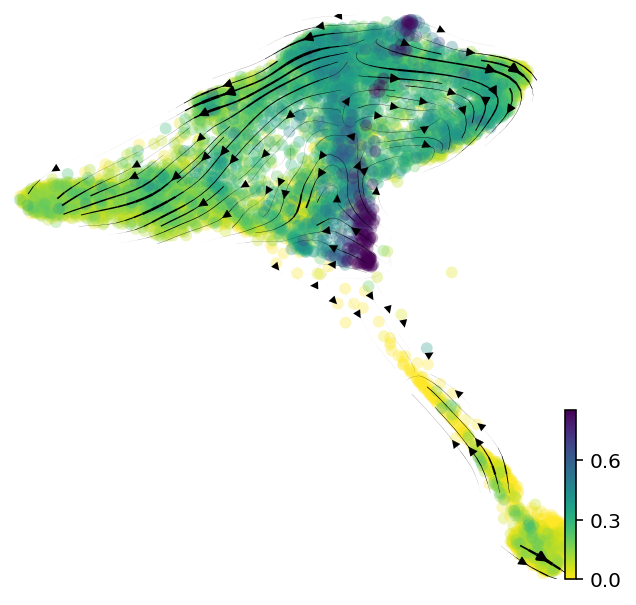

In [190]:
save_name = 'Il2ra_Ms_scatter'

### Plot
rcParams['figure.figsize'] = 5,5
scv.pl.velocity_embedding_stream(adata, basis='paga', frameon=False, title="", color='Il2ra', cmap='viridis_r', layer="Ms",
                                save = "%s.png"%save_name)

In [191]:
save_name = 'Il2ra_Ms_heatmap'

### Plot
gene_use = 'Il2ra'
gene_idx = adata.var.index.tolist().index(gene_use)


rcParams['figure.figsize'] = 5,0.8
cl13_root_df = adata_cl13.obs[['louvain']]
cl13_root_df[gene_use] = adata_cl13.layers['Ms'][:,gene_idx]
cl13_root_df_sum = cl13_root_df.groupby(['louvain']).mean().reset_index()

arm_root_df = adata_arm.obs[['louvain']]
arm_root_df[gene_use] = adata_arm.layers['Ms'][:,gene_idx]
arm_root_df_sum = arm_root_df.groupby(['louvain']).mean().reset_index()

cl13_root_df_sum.columns = ['louvain', 'cl13']
arm_root_df_sum.columns = ['louvain', 'arm']
arm_cl13_root_df = arm_root_df_sum.merge(cl13_root_df_sum, how='outer').set_index('louvain')
arm_cl13_root_df = arm_cl13_root_df.loc[[x for x in louvain_new_ordered if x in arm_cl13_root_df.index.tolist()]]
arm_cl13_root_df = arm_cl13_root_df.round(1)

heatmap = sns.heatmap(arm_cl13_root_df.T, cmap="YlGnBu", vmin=0, vmax=0.5, linecolor='black', linewidth=0.2, annot=True, cbar=False)
plt.savefig(save_name + ".png")
heatmap.set(xticklabels=[])
heatmap.set(yticklabels=[])
plt.savefig(save_name + "_nolabels.png")
plt.show()
plt.close()

## Velocity embedding stream -- Trejcetories

In [192]:
trajectory_streams_dir = wk_dir + '/trajectory_streams'
Path(trajectory_streams_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
t1 = ["P2", "P4", "P9", "P10"]
t2 = ["P3", "P6", "P8", "P9"]
t3 = ["P2", "P7"]
t4 = ["P2", "P5"]

t_dict = {"t1":t1, "t2":t2, "t3":t3,"t4": t4}

adata_use = adata_act_arm
outname_base = "Act-Arm"
gene_list = ['Il2ra', 'Runx3', 'Ctla4', 'Fasl', 'Tcf7', 'Slamf6', 'Tox', 'Ets1','Id2', 'Cxcr6', 'Selplg', 'Il17ra']

use_dir = trajectory_streams_dir + "/" + outname_base
Path(use_dir).mkdir(parents=True, exist_ok=True)
os.chdir(use_dir)

rcParams['figure.figsize'] = 4,4
for t, t_clusters in t_dict.items():
    # Subset trajectory adata
    adata_t = adata_use.copy()
    adata_t = adata_t[[True if x in t_clusters else False for x in adata_t.obs['louvain']]]
    # Calculate plotting range
    x_min_use, x_max_use, y_min_use, y_max_use = subplot_lims(adata_t)
    # Outname for plots
    out_name = "%s_%s_velocity-stream"%(outname_base, t)
    # louvain colored plot
    scv.pl.velocity_embedding_stream(adata_t, basis='paga', legend_fontsize=20, title="",
                                xlim=(x_min_use, x_max_use), ylim=(y_min_use, y_max_use), save = "%s_louvain.png"%out_name)
    # Gene plots
    for gene in gene_list:
        scv.pl.velocity_embedding_stream(adata_t, basis='paga', frameon=False, title="", color=gene, layer="Ms",
                                 xlim=(x_min_use, x_max_use), ylim=(y_min_use, y_max_use), color_map='viridis_r',
                                 save = "%s_%s.png"%(out_name, gene))

saving figure to file ./figures/scvelo_Act-Arm_t1_velocity-stream_louvain.png


saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_louvain.png


saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Il2ra.png


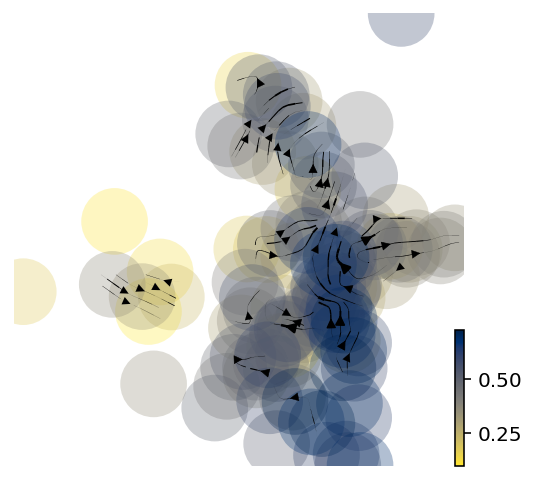

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Runx3.png


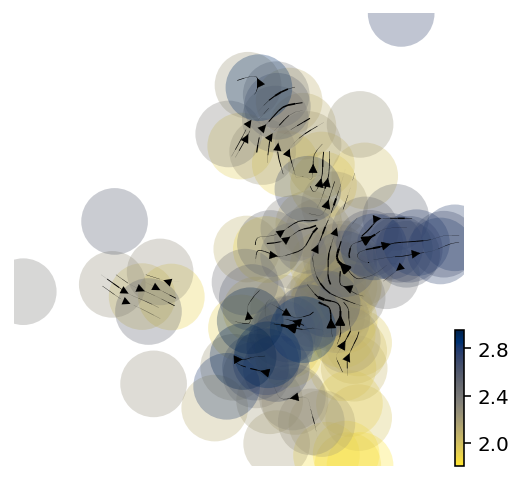

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Ctla4.png


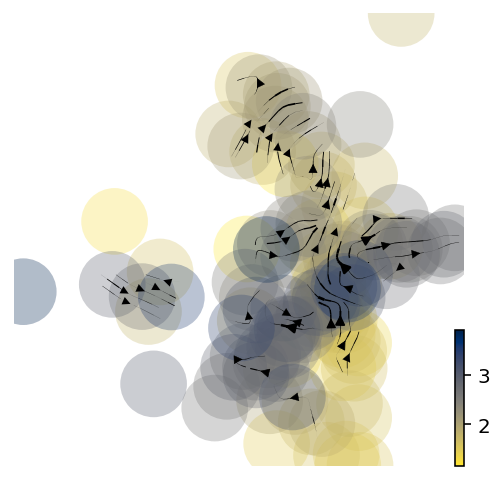

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Fasl.png


saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Tcf7.png


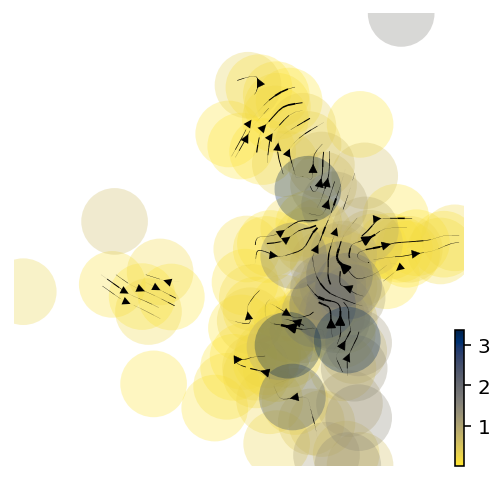

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Slamf6.png


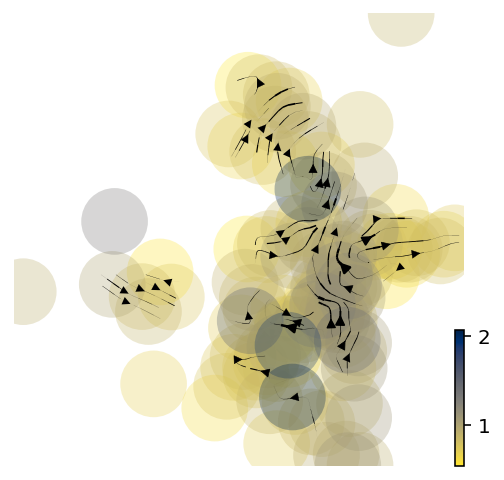

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Tox.png


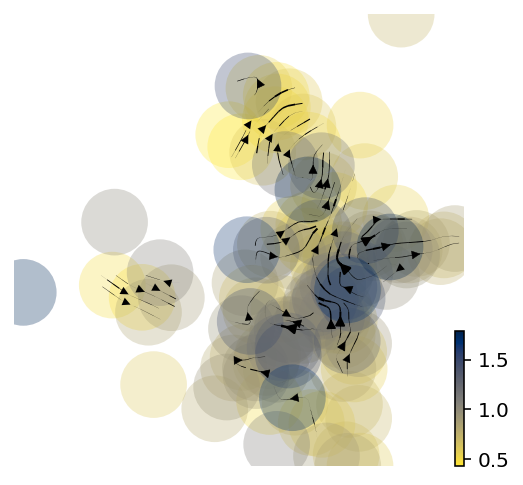

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Ets1.png


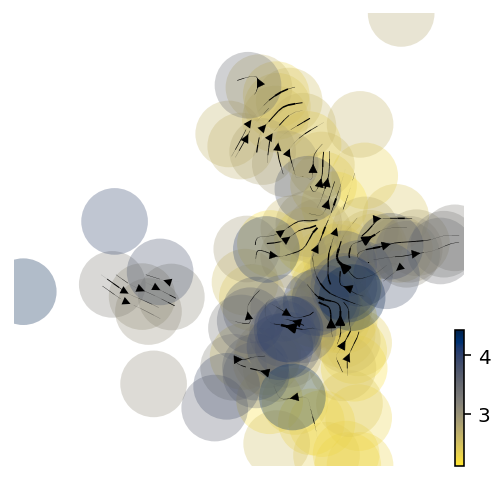

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Id2.png


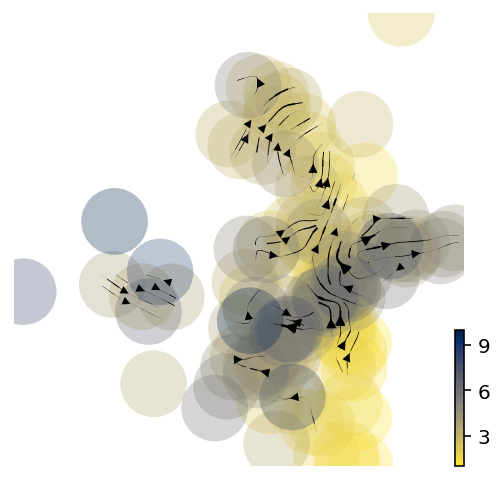

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Cxcr6.png


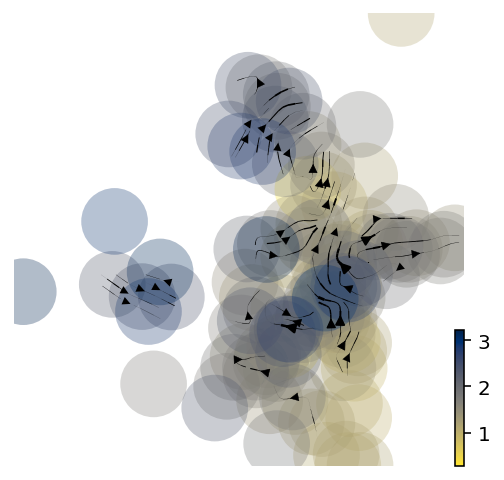

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Selplg.png


saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Il17ra.png


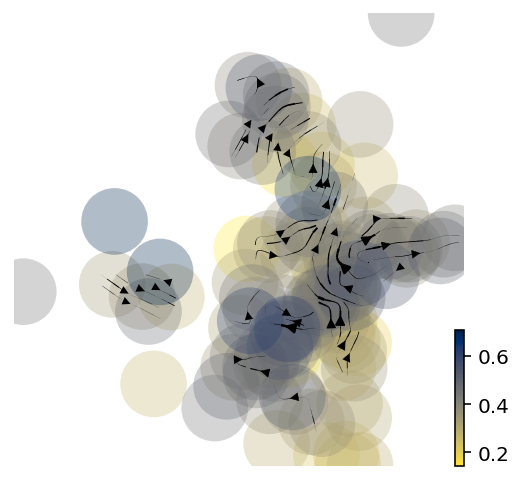

saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_louvain.png


saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_Il2ra.png


saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_Runx3.png


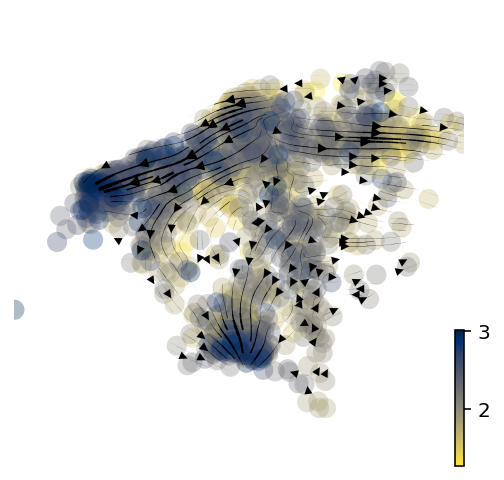

saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_Ctla4.png


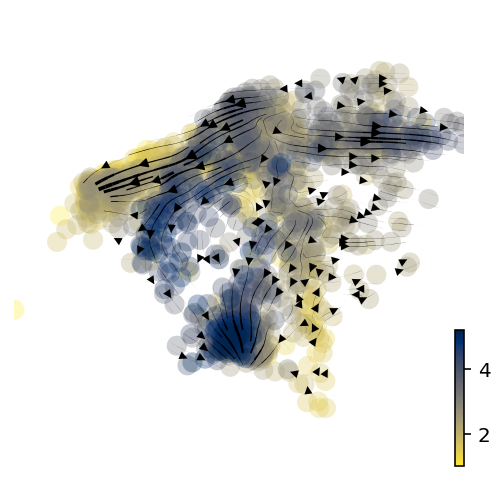

saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_Fasl.png


saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_Tcf7.png


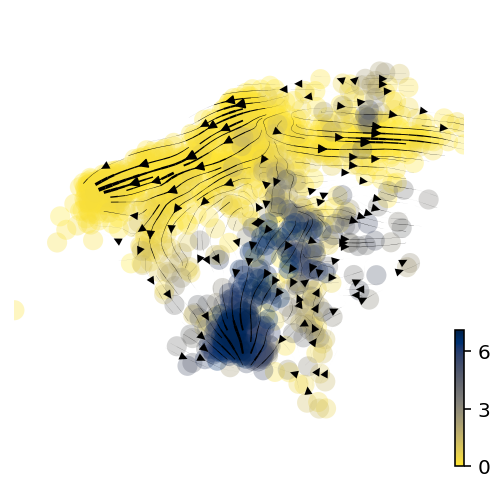

saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_Slamf6.png


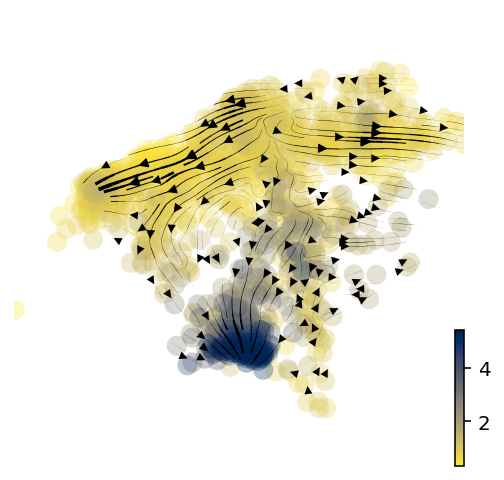

saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_Tox.png


saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_Ets1.png


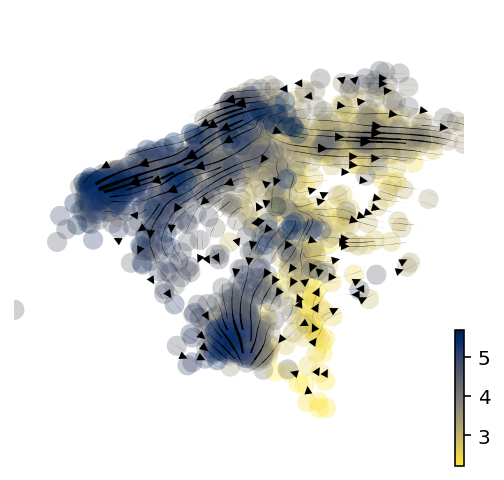

saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_Id2.png


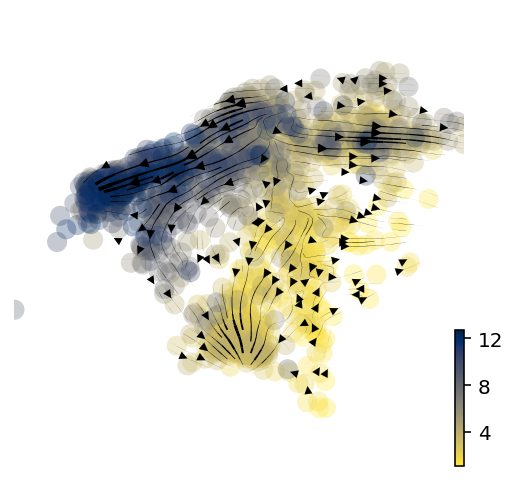

saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_Cxcr6.png


saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_Selplg.png


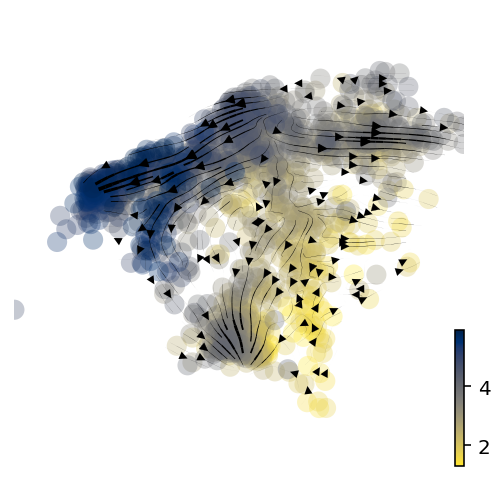

saving figure to file ./figures/scvelo_Act-Cl13_t2_velocity-stream_Il17ra.png


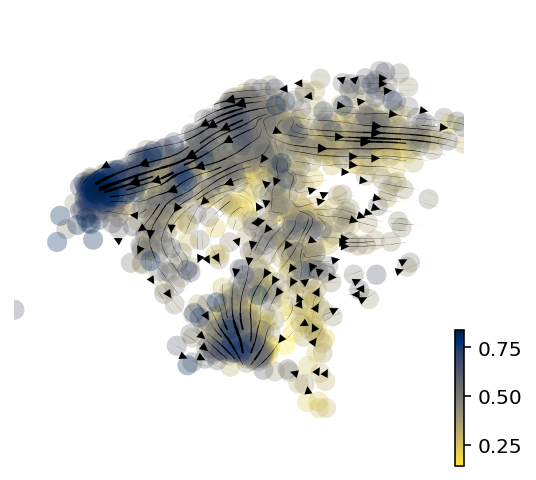

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_louvain.png


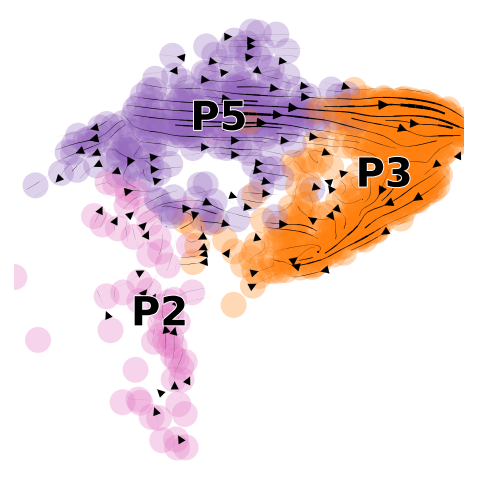

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_Il2ra.png


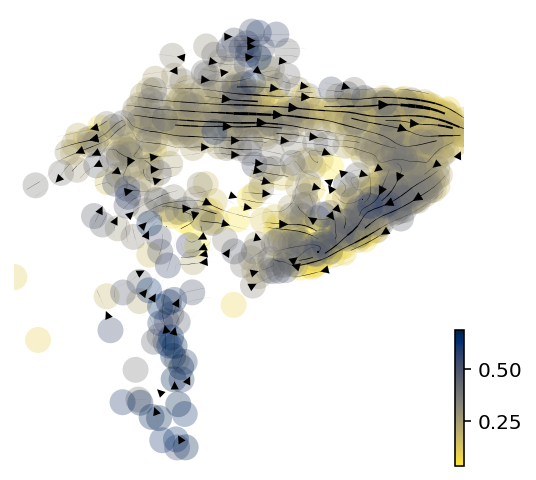

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_Runx3.png


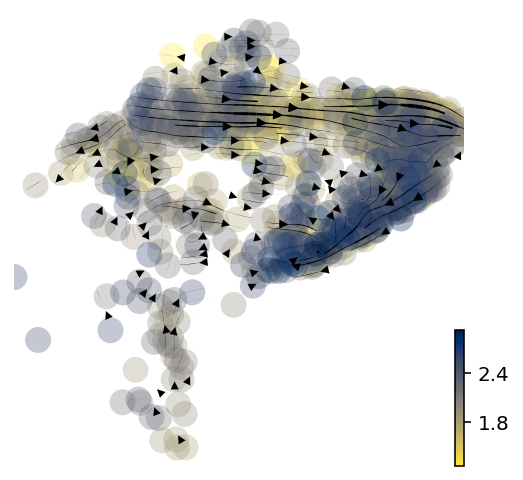

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_Ctla4.png


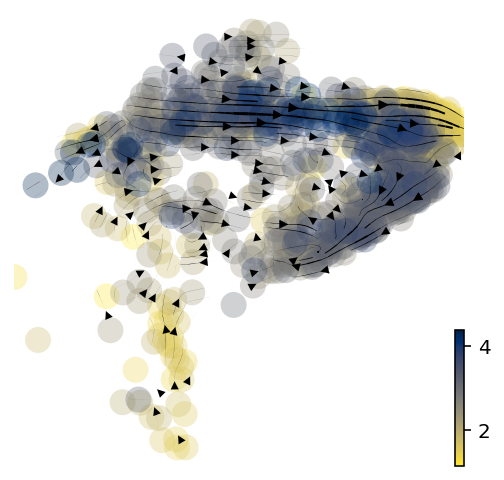

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_Fasl.png


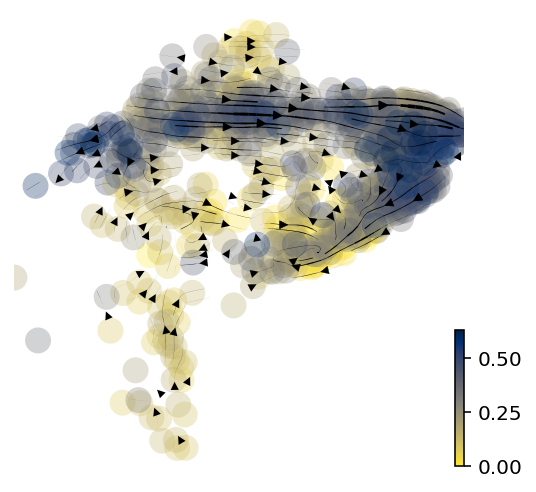

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_Tcf7.png


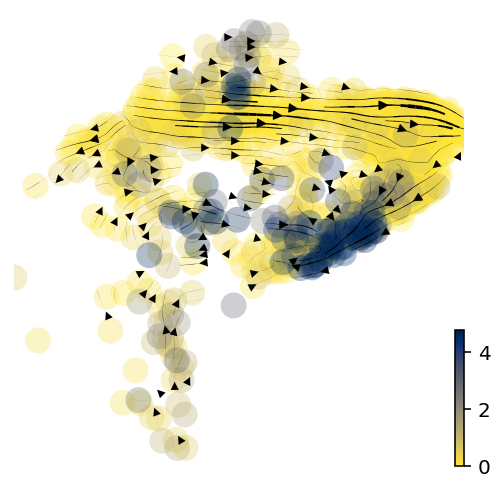

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_Slamf6.png


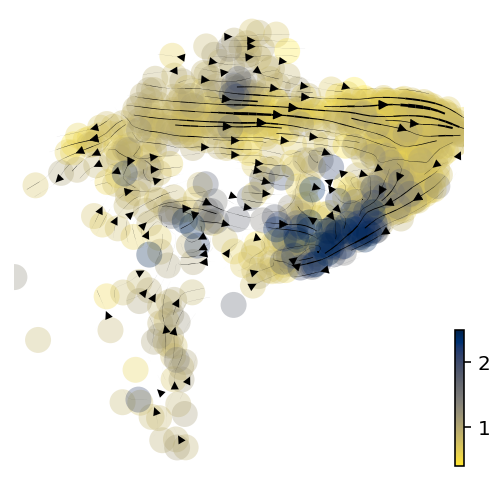

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_Tox.png


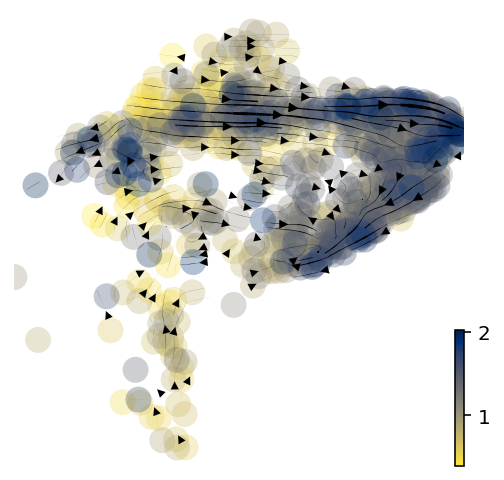

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_Ets1.png


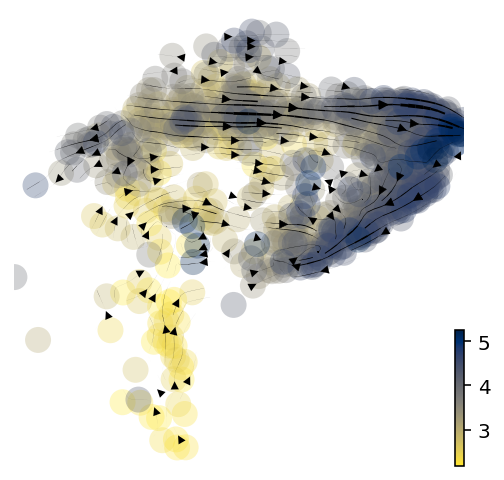

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_Id2.png


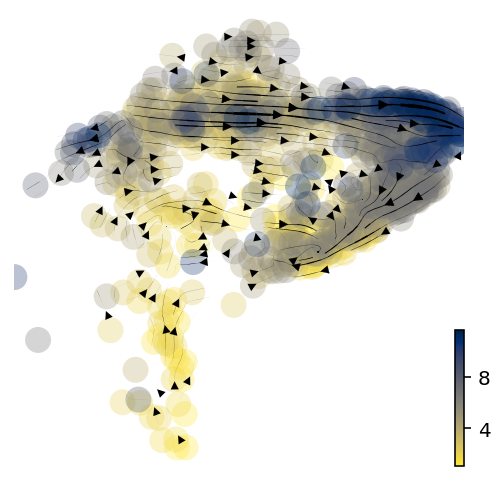

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_Cxcr6.png


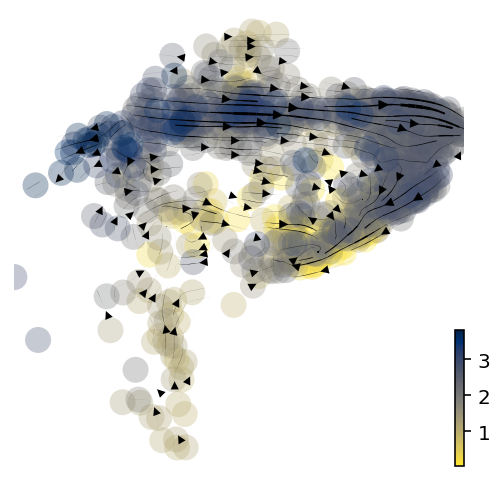

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_Selplg.png


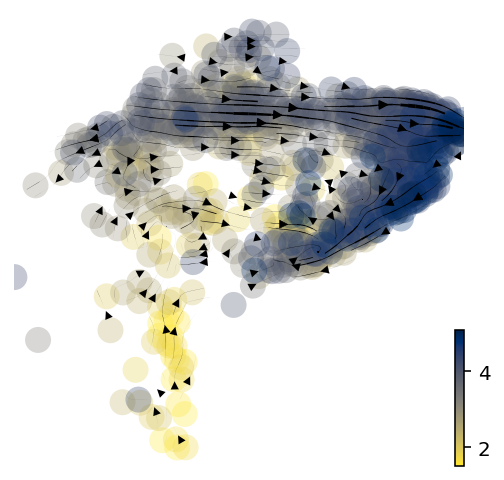

saving figure to file ./figures/scvelo_Act-Cl13_t3_velocity-stream_Il17ra.png


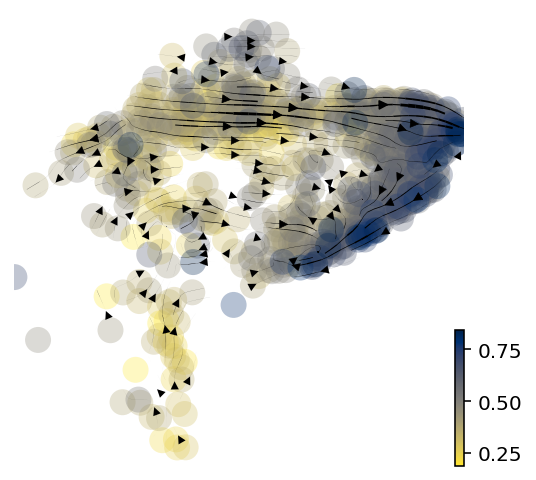

In [189]:
t1 = ["P2", "P4"]
t2 = ["P2", "P5", "P6", "P7", "P8"]
t3 = ["P2", "P5", "P3"]

t_dict = {"t1":t1, "t2":t2, "t3":t3}

adata_use = adata_act_cl13
outname_base = "Act-Cl13"
gene_list = ['Il2ra', 'Runx3', 'Ctla4', 'Fasl', 'Tcf7', 'Slamf6', 'Tox', 'Ets1','Id2', 'Cxcr6', 'Selplg', 'Il17ra']

use_dir = trajectory_streams_dir + "/" + outname_base
Path(use_dir).mkdir(parents=True, exist_ok=True)
os.chdir(use_dir)

rcParams['figure.figsize'] = 4,4
for t, t_clusters in t_dict.items():
    # Subset trajectory adata
    adata_t = adata_use.copy()
    adata_t = adata_t[[True if x in t_clusters else False for x in adata_t.obs['louvain']]]
    # Calculate plotting range
    x_min_use, x_max_use, y_min_use, y_max_use = subplot_lims(adata_t)
    # Outname for plots
    out_name = "%s_%s_velocity-stream"%(outname_base, t)
    # louvain colored plot
    scv.pl.velocity_embedding_stream(adata_t, basis='paga', legend_fontsize=20, title="",
                                xlim=(x_min_use, x_max_use), ylim=(y_min_use, y_max_use), save = "%s_louvain.png"%out_name)
    # Gene plots
    for gene in gene_list:
        scv.pl.velocity_embedding_stream(adata_t, basis='paga', frameon=False, title="", color=gene, layer="Ms",
                                 xlim=(x_min_use, x_max_use), ylim=(y_min_use, y_max_use), color_map='cividis_r',
                                 save = "%s_%s.png"%(out_name, gene))
